## Model the Target as Binary Variable - Classification Problem

#### Load Libraries

In [43]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import os
import subprocess
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV

#### Load the surrounding and sales data and join them to create a data set for learning

In [17]:
surrounding_pdf = pd.read_csv('../UseCase_3_Datasets/store_surrounding_pdf_exp.csv')
surrounding_nf_pdf = pd.read_csv('../UseCase_3_Datasets/new_features.csv')

surrounding_pdf = pd.merge(surrounding_nf_pdf,surrounding_pdf,on='store_code',how='inner')
surrounding_pdf = surrounding_pdf.drop_duplicates()

y_column = 'total_sales'

# store_sales = pd.read_csv('../UseCase_3_Datasets/sales_daily_simple_sum.csv')
# sales_pdf_daily_sub = store_sales[['store_code','total_sales']]

#store_sales = pd.read_csv('../UseCase_3_Datasets/sales_per_hr.csv')
#sales_pdf_daily_sub = store_sales[['store_code','sales_per_hr']]

store_sales = pd.read_csv('../UseCase_3_Datasets/sales_per_day_period.csv')
sales_pdf_daily_sub = store_sales[['store_code','total_sales','Morning','Afternoon','Evening','sales_pattern']]
# sales_pdf_daily_sub = sales_pdf_daily_sub[(sales_pdf_daily_sub['sales_pattern'] == 'Evening') |
#                                           (sales_pdf_daily_sub['sales_pattern'] == 'Afternoon')]
sales_pdf_daily_sub = sales_pdf_daily_sub[['store_code',y_column]]


In [18]:
# # #Read other population realted information from wiki
# pop_features_pdf = pd.read_csv('../UseCase_3_Datasets/swiss_pop_features_2.csv',sep=';',header=0)
# pop_features_pdf.head()
# pop_features_pdf.columns
# pop_pdf = pd.read_csv('../UseCase_3_Datasets/swiss_pop.csv',sep=',')
# pop_pdf.head()

# # #Comnine with surrounding data using city code informartion
# surrounding_pdf = pd.merge(pop_features_pdf,surrounding_pdf,on='city',how='inner')
# surrounding_pdf = surrounding_pdf.drop_duplicates()
# surrounding_pdf = pd.merge(pop_pdf,surrounding_pdf,on='city',how='inner')
# surrounding_pdf = surrounding_pdf.drop_duplicates()
# surrounding_pdf['pop_above_20'] = 100-surrounding_pdf['pop_under_20']
# surrounding_pdf= surrounding_pdf.drop('cant',axis=1)
# surrounding_pdf.head()

In [19]:
print("Surrounding Shape",surrounding_pdf.shape)
print("Sales Shape",sales_pdf_daily_sub.shape)

Surrounding Shape (525, 705)
Sales Shape (905, 2)


### Data Cleaning

#### Remove variable that have ony one unique value

In [20]:
#Join Store and Surroounding datasets
sales_surrounding_pdf = pd.merge(sales_pdf_daily_sub,surrounding_pdf,on='store_code',how='inner')
sales_surrounding_pdf = sales_surrounding_pdf.drop_duplicates()
# Dropping columns that do not provide useful information for this analysis
for i in sales_surrounding_pdf.columns:
    if sales_surrounding_pdf[i].nunique() == 1:
        sales_surrounding_pdf.drop(i, axis = 1, inplace = True)
print("Sales Surrounding Shape",sales_surrounding_pdf.shape)

Sales Surrounding Shape (524, 699)


In [21]:
# #Visualization of individual attributes
# #Histogram
# sales_surrounding_pdf.hist(sharex=False,sharey=False,xlabelsize=0.25,ylabelsize=0.25,figsize=(20,20))
# pyplot.show()

In [22]:
# sales_surrounding_pdf.plot(kind='density', subplots=True, layout=(10,18), sharex=False, legend=False,fontsize=1,
#                           figsize=(20,20))
# pyplot.show()

In [23]:
# fig = pyplot.figure(figsize=(15,15))
# ax = fig.add_subplot(111)
# cax = ax.matshow(sales_surrounding_pdf.corr(),vmin=-1, vmax=1)
# fig.colorbar(cax)
# pyplot.show()

#### One hot Encoding for categorical values

In [24]:
import math

sales_surrounding_pdf_ohe = pd.get_dummies(sales_surrounding_pdf)
#Create Train,Test without imputation
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'total_sales']
#X = sales_surrounding_pdf.loc[:, sales_surrounding_pdf.columns != 'store_code']

y = sales_surrounding_pdf_ohe[y_column].apply(lambda x : math.log(x+1))
X = sales_surrounding_pdf_ohe.drop([y_column,'store_code'],axis=1)
#X = sales_surrounding_pdf.drop('store_code',axis=1)

# print("Shape ",X.shape)
# print ("Shape ",y.shape )

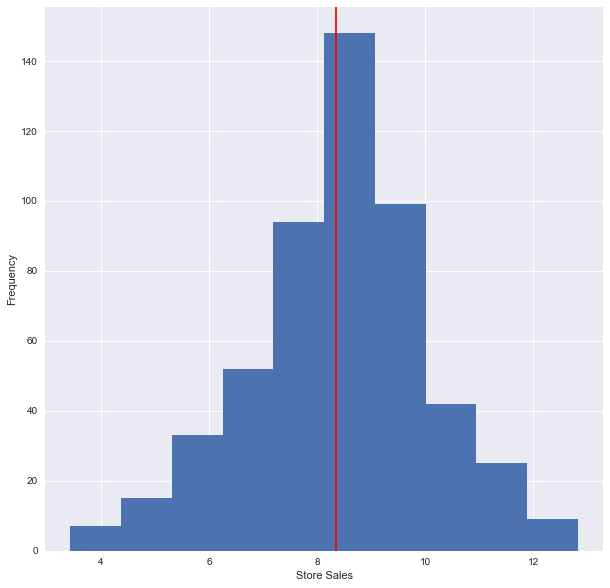

In [25]:
y.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),grid=True,)
# y_test.hist(bins=20,figsize=(10,10))
pyplot.axvline(x=8.35,color='red')
pyplot.xlabel("Store Sales")
pyplot.show()

#### Creation of Test and Train set

In [26]:
#Divide into train and test
validation_size = 0.20
seed = 33
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=validation_size,random_state=seed)

#### Target Creation
Since we plan to make a binary target, we try to find a split point, looking at the data 
Also, the split point is created in such a way, that we do dont create a unbalanced dataset to learn and predict.

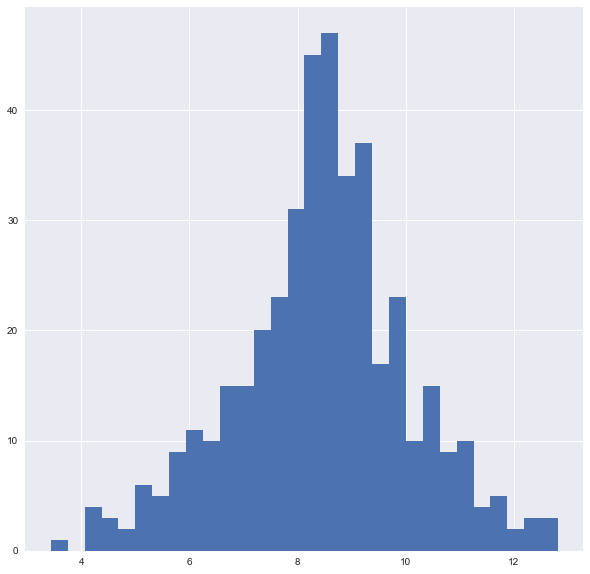

In [27]:
# xtick_list = range(0,500000,50000)
# ytick_list = range(0,y_train.shape[0],30)
# y_train.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),xticks=xtick_list,yticks=ytick_list)
y_train.hist(bins=30,figsize=(10,10))
# pyplot.xlabel("Store Sales")
# pyplot.show()

In [28]:
# y_train[y_train.values < 8].hist(bins=30,figsize=(10,10),)
# pyplot.xlabel("Store Sales")
# pyplot.show()

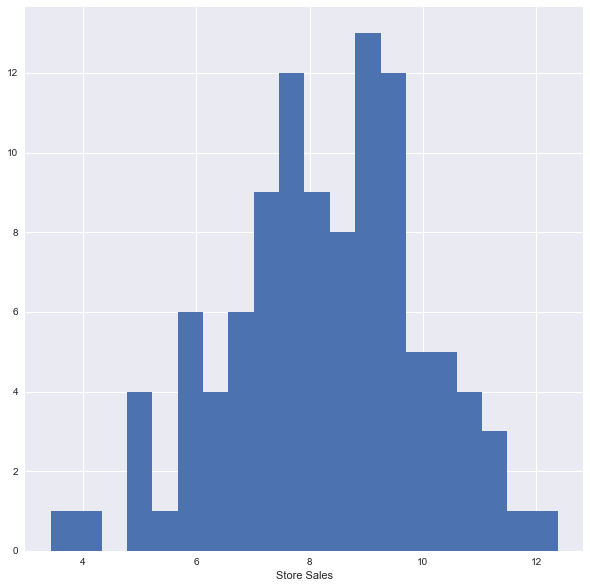

In [29]:
# xtick_list = range(0,500000,50000)
# ytick_list = range(0,y_test.shape[0],10)
#y_test.plot(kind='hist',subplots=True,fontsize=10,figsize=(10,10),grid=True,xticks=xtick_list,yticks=ytick_list)
y_test.hist(bins=20,figsize=(10,10))
pyplot.xlabel("Store Sales")
pyplot.show()

In [30]:
#Find the most balanced point of the data set :

# for i in np.arange(7,10,0.15):
#     y_train_sp = y_train.apply(lambda x : 1 if x >=i else 0 )
#     y_test_sp = y_test.apply(lambda x : 1 if x >=i else 0)
#     print ("Split Point ", i)
#     print ("% of 0-class in Test ",y_test_sp.value_counts()[0]/ (y_test_sp.value_counts()[1]+y_test_sp.value_counts()[0])*100)
#     print ("% of 0-class in Train ",y_train_sp.value_counts()[0]/ (y_train_sp.value_counts()[1]+y_train_sp.value_counts()[0])*100)
#     print("\n")

On the spot checks,try out some basic models and see, how they perform 

Since our goal is interpret-ability of our features, we will stick to models like Logistic regression, Decision Tree. Ensemble methods too can be used, since they provide a feature importance indication .

In the below cells, we try out various algorithms. Use grid search to best tune the hyper parameters and using  cross - validation, to ensure we do not over fit the training data.

In [36]:
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

seed = 13
dtcf = DecisionTreeRegressor(max_depth=1,random_state=seed) 

# n_estimator = list(range(10,500,10))
#print(dtcf.get_params)
param_grid = { 
    
    'max_depth': list(range(1,10,3)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(2,20,1))
}

CV_dtcf = RandomizedSearchCV(estimator=dtcf,param_distributions=param_grid, cv= 5,scoring='mean_squared_error')
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
print (CV_dtcf.best_score_)


predictions_train = CV_dtcf.best_estimator_.predict(X_train)
print("Train ROC-AUC :",mean_squared_error(y_train, predictions_train))
predictions = CV_dtcf.best_estimator_.predict(X_test)
print("Test ROC_AUC :",mean_squared_error(y_test, predictions))


{'min_samples_split': 14, 'max_features': 'log2', 'max_depth': 1}
-2.458542169492869
Train ROC-AUC : 2.46422502227
Test ROC_AUC : 3.31670368617


In [37]:
seed=13
model = DecisionTreeRegressor(max_depth=3,criterion='mse',random_state=seed)
model.fit(X_train, y_train)
#estimate on train data
predictions_train = model.predict(X_train)
print("Train ROC-AUC :",mean_squared_error(y_train, predictions_train))
print("Train ROC-AUC R2:",r2_score(y_train, predictions_train))

predictions = model.predict(X_test)
print("Test ROC_AUC :",mean_squared_error(y_test, predictions))
print("Test ROC_AUC R2:",r2_score(y_test, predictions))
#visualize_tree(model, X_train.columns,"dt_entropy.txt")

Train ROC-AUC : 1.82727242787
Train ROC-AUC R2: 0.302542649581
Test ROC_AUC : 2.75240278049
Test ROC_AUC R2: 0.0695274876977


In [39]:
# Build a forest and compute the feature importances
def visualizeFeatureImportance(model,feature_names,no_of_features):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    features = no_of_features
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(features):
        print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure(figsize=(10,10))
    plt.title("Feature importances")
    plt.bar(range(features), importances[indices[:features]],color="r", yerr=std[indices[:features]], align="center")
    plt.xticks(range(features), indices[:features])
    plt.xlim([-1,features])
    plt.show()

Train ROC-AUC : 2.08592588746
Train ROC-AUC R2: 0.203816398451
Test ROC_AUC : 2.85395446829
Test ROC_AUC R2: 0.0351971001723
Feature ranking:
1. feature n_rating_per_entity_store_spa (0.080564)
2. feature avr_university (0.079953)
3. feature nf_enity_store_id_hair_care (0.073596)
4. feature entity_per_store_jewelry_store (0.062062)
5. feature rating_dentist (0.054427)
6. feature entity_per_store_gym (0.054051)
7. feature total_user_rating_book_store (0.047671)
8. feature nf_enity_store_id_pharmacy (0.043475)
9. feature city_GE (0.041493)
10. feature rating_per_entity_store_spa (0.037314)


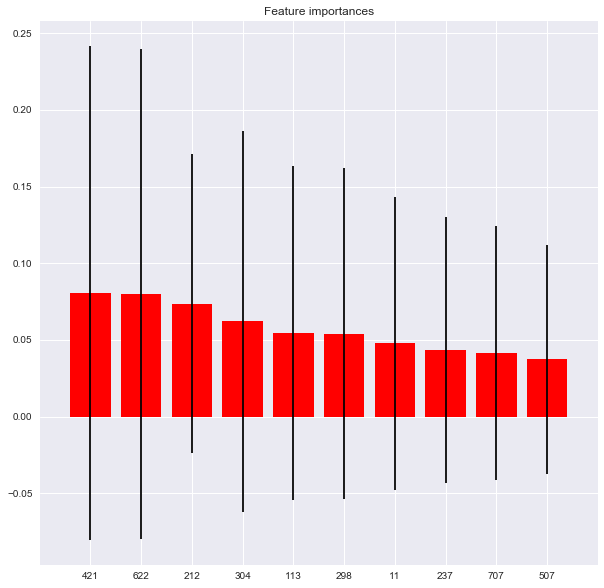

In [40]:
seed = 19
rf_clf = RandomForestRegressor(n_estimators=5,max_depth=3,random_state=seed,max_features='sqrt')
rf_clf.fit(X_train,y_train)
predictions_train = rf_clf.predict(X_train)
print("Train ROC-AUC :",mean_squared_error(y_train, predictions_train))
print("Train ROC-AUC R2:",r2_score(y_train, predictions_train))
# estimate accuracy on validation dataset

predictions = rf_clf.predict(X_test)
print("Test ROC_AUC :",mean_squared_error(y_test, predictions))
print("Test ROC_AUC R2:",r2_score(y_test, predictions))
visualizeFeatureImportance(rf_clf,X_train.columns,10)

Train ROC-AUC : 2.1568335901
Train ROC-AUC R2: 0.176751414785
Test ROC_AUC : 2.84732748939
Test ROC_AUC R2: 0.0374374051704
Feature ranking:
1. feature entity_per_store_gym (0.099247)
2. feature n_store (0.065265)
3. feature rating_laundry (0.061222)
4. feature n_rating_per_entity_store_library (0.060532)
5. feature avr_gym (0.057792)
6. feature entity_per_store_night_club (0.051455)
7. feature rating_per_entity_store_electronics_store (0.050205)
8. feature avr_university (0.043898)
9. feature n_liquor_store (0.041086)
10. feature rating_dentist (0.040675)


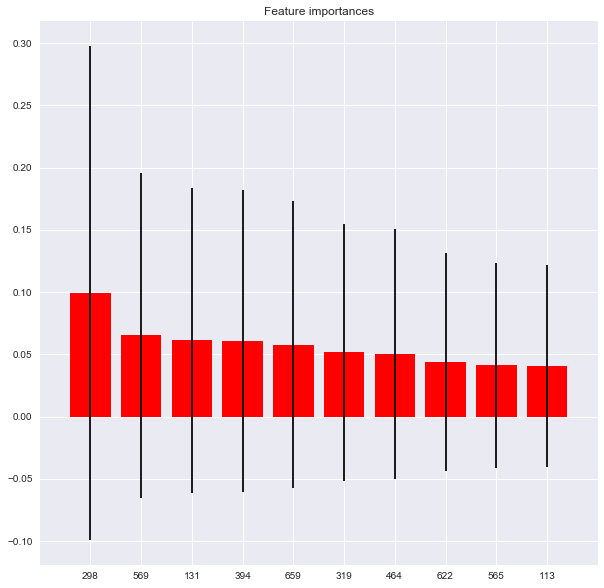

In [45]:
# prepare the model

seed = 17

model_et = ExtraTreesRegressor(n_estimators=5,max_depth=3,bootstrap=True,max_features='sqrt',random_state=seed)
model_et.fit(X_train, y_train)

predictions_train = model_et.predict(X_train)
print("Train ROC-AUC :",mean_squared_error(y_train, predictions_train))
print("Train ROC-AUC R2:",r2_score(y_train, predictions_train))
# estimate accuracy on validation dataset

predictions = model_et.predict(X_test)
print("Test ROC_AUC :",mean_squared_error(y_test, predictions))
print("Test ROC_AUC R2:",r2_score(y_test, predictions))
visualizeFeatureImportance(model_et,X_train.columns,10)

In [51]:
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression

validation_size = 0.30
seed = 13
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

scaler = Normalizer().fit(X_train)
normalizedX = scaler.transform(X_train)

lr = LinearRegression() 

In [53]:
lr.fit(normalizedX, y_train)

predictions_train = lr.predict(normalizedX)
print("Train AUC :",mean_squared_error(y_train,predictions_train))

normalizedX_test = scaler.transform(X_test)
predictions = lr.predict(normalizedX_test)

print("Test ROC_AUC :",mean_squared_error(y_test, predictions))

Train AUC : 1.09411241067e-26
Test ROC_AUC : 816.264377319


In [54]:
# from tpot import TPOTClassifier

# # prepare the model
# model = TPOTClassifier(generations=5, population_size=50, verbosity=2,cv=10,scoring='roc_auc')
# model.fit(X_train, y_train)

# predictions = model.predict(X_test)

# print(roc_auc_score(y_test, predictions))
# print(confusion_matrix(y_test, predictions))


Sci-kit learn provide facilities from feature selection to improve estimators accuracy scores or to boost their performance on very high-dimensional datasets.

We compute the ANOVA F-value for the data, using the SelectKBest methods and use these as inputs to various algorithms. 

In [55]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression
import pandas as pd


selector = SelectKBest(f_regression, k=15)
selector.fit(X, y)
X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
f_classif_list = X.columns[selector.get_support(indices=True)].tolist()
print(f_classif_list,"\n")
    
selector = SelectKBest(mutual_info_regression, k=15)
selector.fit(X, y)
X_new = selector.transform(X)
X_new.shape
X.columns[selector.get_support(indices=True)]
mic_list  = X.columns[selector.get_support(indices=True)].tolist()
print(mic_list,"\n")
    

['entity_per_store_department_store', 'n_rating_per_entity_store_hair_care', 'rating_per_entity_store_spa', 'n_pharmacy', 'n_meal_takeaway', 'n_store', 'n_gym', 'n_dentist', 'n_spa', 'n_cafe', 'n_doctor', 'n_bakery', 'near_by_post_code', 'n_review', 'city_VD'] 

['total_user_rating_home_goods_store', 'total_user_rating_store', 'rating_doctor', 'rating_hair_care', 'rating_pharmacy', 'nf_enity_store_id_pharmacy', 'entity_per_store_clothing_store', 'entity_per_store_pharmacy', 'entity_per_store_shoe_store', 'n_rating_per_entity_store_hair_care', 'rating_per_entity_store_hair_care', 'rating_per_entity_store_pharmacy', 'avr_pharmacy', 'avr_hair_care', 'avr_doctor'] 



In [57]:
#First Level of segregation using f_classif_list
X_sub = X[X.columns.intersection(f_classif_list)]
y_sub = y

print("Shape ",X_sub.shape)
print ("Shape ",y.shape )


#Divide 
validation_size = 0.30
seed = 19

X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=validation_size,random_state=seed)

dtcf = DecisionTreeRegressor(max_depth=2,random_state=seed) 


param_grid = { 
    
    'max_depth': list(range(2,10,1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(2,20,1))
}

CV_dtcf = RandomizedSearchCV(estimator=dtcf,param_distributions=param_grid, cv= 5,scoring='mean_squared_error',
                             random_state=seed)
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
#print (CV_dtcf.best_score_)


predictions_train = CV_dtcf.best_estimator_.fit(X_train, y_train).predict(X_train)
print("Train ROC-AUC :",mean_squared_error(y_train, predictions_train))
print("Train ROC-AUC R2:",r2_score(y_train, predictions_train))

predictions = CV_dtcf.best_estimator_.predict(X_test)
print("Test ROC-AUC :",mean_squared_error(y_test, predictions))
print("Test ROC-AUC R2:",r2_score(y_test, predictions))



Shape  (524, 15)
Shape  (524,)
{'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 4}
Train ROC-AUC : 1.9615044096
Train ROC-AUC R2: 0.240734367133
Test ROC-AUC : 3.38936351225
Test ROC-AUC R2: -0.163375125817


In [40]:
#Overall data set 
validation_size = 0.30
seed = 17

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=validation_size,random_state=seed)

dtcf = DecisionTreeClassifier(max_depth=2,random_state=seed) 


param_grid = { 
    
    'max_depth': list(range(2,10,1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split' : list(range(3,10,1)),
     'criterion':['entropy','gini']
}

CV_dtcf = RandomizedSearchCV(estimator=dtcf,param_distributions=param_grid, cv= 5,scoring='roc_auc',
                             random_state=seed)
CV_dtcf.fit(X_train, y_train)

print (CV_dtcf.best_params_)
#print (CV_dtcf.best_score_)

predictions_train = CV_dtcf.best_estimator_.fit(X_train, y_train).predict_proba(X_train)[:,1]
print("Train ROC-AUC :",roc_auc_score(y_train, predictions_train))

# estimate accuracy on validation dataset
predictions = CV_dtcf.best_estimator_.predict_proba(X_test)[:,1]
print("Test ROC-AUC :" , roc_auc_score(y_test, predictions))


{'min_samples_split': 8, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'gini'}
Train ROC-AUC : 0.689337349398
Test ROC-AUC : 0.621794871795


In [41]:
# {criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 15}
# {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 4}
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 11}

Shape  (524, 29)
Shape  (524,)
{'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 160}
Train ROC-AUC : 0.571391390556
Test ROC-AUC : 0.110721887059
Feature ranking:
1. feature n_review (0.064600)
2. feature n_rating_per_entity_store_hair_care (0.054649)
3. feature total_user_rating_store (0.049017)
4. feature total_user_rating_home_goods_store (0.044741)
5. feature avr_hair_care (0.043716)
6. feature rating_hair_care (0.043304)
7. feature city_VD (0.042251)
8. feature n_store (0.042038)
9. feature entity_per_store_clothing_store (0.041810)
10. feature rating_per_entity_store_hair_care (0.041137)


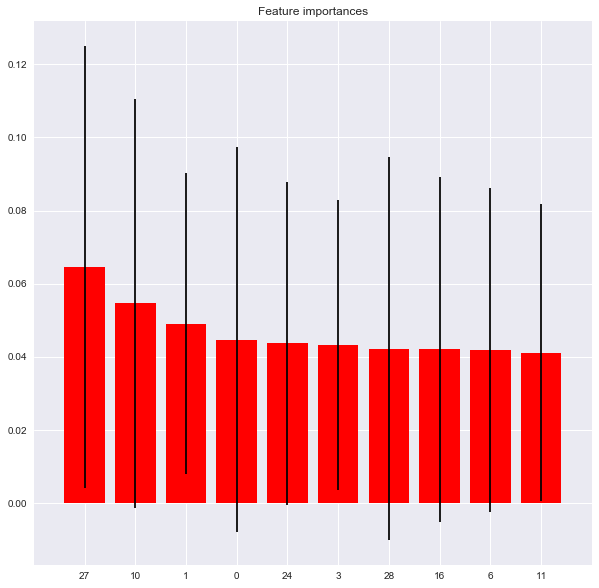

{'bootstrap': False, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 320}
Train ROC-AUC : 1.75544160594
Test ROC-AUC : 2.29376841202
Feature ranking:
1. feature city_VD (0.213645)
2. feature entity_per_store_department_store (0.081072)
3. feature n_store (0.055730)
4. feature n_gym (0.052058)
5. feature n_spa (0.047062)
6. feature rating_hair_care (0.047000)
7. feature avr_hair_care (0.043182)
8. feature n_meal_takeaway (0.040435)
9. feature n_rating_per_entity_store_hair_care (0.037625)
10. feature n_bakery (0.036993)


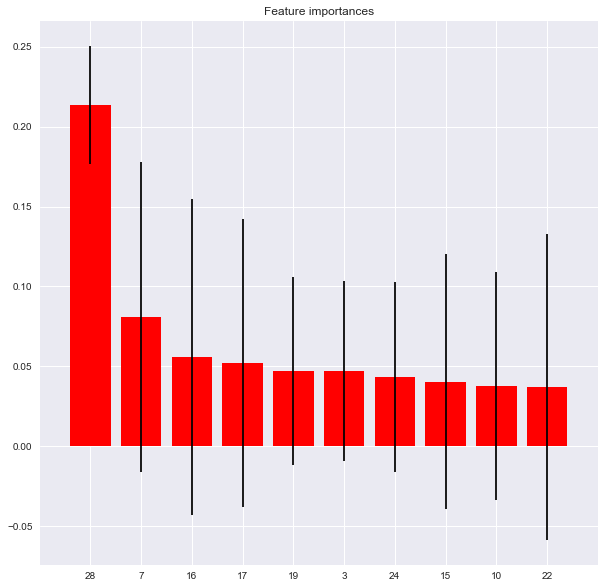

In [62]:
ensemble_input_col = list(set().union(f_classif_list,mic_list))
#ensemble_input_col = list(set().union(f_classif_list))

X_sub = X[X.columns.intersection(ensemble_input_col)]
y_sub = y


print("Shape ",X_sub.shape)
print ("Shape ",y.shape )


#Divide 
validation_size = 0.30
seed = 29
X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=validation_size,random_state=seed)


from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

rfc = RandomForestRegressor(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,9,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False]
}

CV_rfc = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid,cv= 5,scoring='mean_squared_error')
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

seed = 29
rf_clf = CV_rfc.best_estimator_

rf_clf.fit(X_train,y_train)
predictions_train = rf_clf.predict(X_train)
print("Train ROC-AUC :",r2_score(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = rf_clf.predict(X_test)
print("Test ROC-AUC :",r2_score(y_test, predictions))
visualizeFeatureImportance(rf_clf,X_train.columns,10)

et_clf = ExtraTreesRegressor(n_jobs=-1) 

# n_estimator = list(range(10,500,10))
# print(n_estimator)
param_grid = { 
    'n_estimators': list(range(10,500,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : list(range(3,9,1)),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(2, 11),
    "bootstrap": [True, False]
}

CV_et_clf = RandomizedSearchCV(estimator=et_clf,param_distributions=param_grid,cv= 5,scoring='mean_squared_error')
CV_et_clf.fit(X_train, y_train)
print (CV_et_clf.best_params_)


seed = 29
et_clf = CV_et_clf.best_estimator_
et_clf.fit(X_train,y_train)
predictions_train = et_clf.predict(X_train)
print("Train ROC-AUC :",mean_squared_error(y_train, predictions_train))
# estimate accuracy on validation dataset
predictions = et_clf.predict(X_test)
print("Test ROC-AUC :",mean_squared_error(y_test, predictions))
visualizeFeatureImportance(et_clf,X_train.columns,10)


In [50]:
# effect_list = []
# for i in range(0,len(X.columns)):
#     if lr.coef_[:,i]!=0:
#         effect_list.append(X.columns[i]+str(lr.coef_[:,i]))
# print ("LR feature co-efficient :",effect_list)